In [495]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav

import tol_colors
from scipy.interpolate import interp1d
from scipy.signal import convolve
from labellines import *
import scipy

300000000000.0

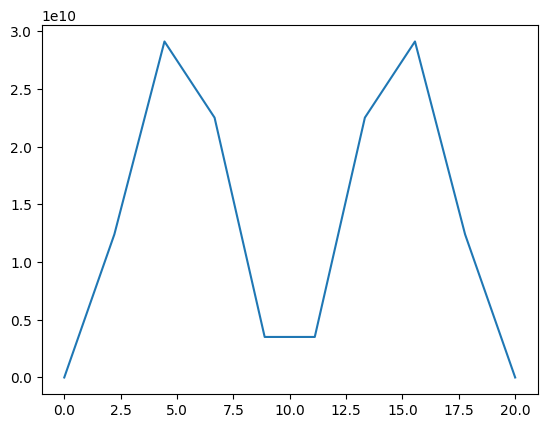

In [497]:
x_values = np.linspace(0, 20, 10)
y_values = 3e10 * (np.sin(np.pi * x_values))**2

plt.plot(x_values,y_values)
np.trapz(y_values,x_values)

In [499]:
300000000000/1e11

3.0

In [501]:
timesinit = np.arange(0,500,30)
timesinit

array([  0,  30,  60,  90, 120, 150, 180, 210, 240, 270, 300, 330, 360,
       390, 420, 450, 480])

In [503]:
# before this, will need to save variables tg1t, z1t, ne1t, pg1t, q, nq, qnorm, outintt, nmu to save file... or access some other way
#filename='/Users/coletamburri/Desktop/radyn_15_8_5e10.sav'
#filename='/Users/coletamburri/Desktop/August_2022_Observations_Paper/radynout.sav'
filename_updatedradyn = '/Users/coletamburri/Desktop/15_8_t3e10_longdur_noRC.sav'
filename_oldradyn = '/Users/coletamburri/Desktop/August_2022_Observations_Paper/radynout.sav'
filename_updatedradyn = '/Users/coletamburri/Desktop/RADYN_Grid_For_Rahul/15_8_5e10_wRC.sav'
filename_rhversion = '/Users/coletamburri/Desktop/RH_Versions_and_Tools/RH_output_files_npz/fchroma30_1b_2vt_43s.npz'
filename_rhversion = '/Users/coletamburri/Desktop/RH_Versions_and_Tools/RH_output_files_npz/cat_15_8_5e10_wRC_updated_48s_H6.npz'
filename_rhversion_CRD = '/Users/coletamburri/Desktop/RH_Versions_and_Tools/RH_output_files_npz/cat_15_8_5e10_wRC_updated_48s_H6_CRD.npz'

filename_rhqs = '/Users/coletamburri/Desktop/RH_Versions_and_Tools/RH_output_files_npz/cat_15_8_5e10_wRC_updated_0s_H6_CRD.npz'
filename_dkist = '/Users/coletamburri/Desktop/RH_Versions_and_Tools/RH_output_files_npz/dkist_obs_file.npz'

# change based on desired line and fwhm of observations

kr=16 #Ca II H - 20 is Ca II 8542
#timesinit = np.arange(0,500,30)
#timesinit = [0,66.7,133.3,200,250,430,480,490,500] #times to print out in plots, in decaseconds
timesinit=[480]
 #decay phase times to print out in plots - will be concatenated to timesinit array
lamb0=396.846 # change this and the instances below to wavelength of spectral line in nm as desired (as needed)
c=2.99e5
mu=.5 #viewing angle cos(theta) - choose between 0.05, 0.23, 0.5, 0.77, 0.95
muind = 2 # index corresponding to the value above; 0=0.05, 1=0.23, 2=0.5, 3=0.77, 4=0.95
fwhm=.05 #dkist FWHM
ntw=45 # DKIST NTW


In [505]:
read_oldradyn = readsav(filename_oldradyn)
read_newradyn = readsav(filename_updatedradyn)
read_rhversion = np.load(filename_rhversion)
read_rhversion_CRD = np.load(filename_rhversion_CRD)
read_rhqs = np.load(filename_rhqs)

In [507]:
ret=doppler_shift(lamb0,read_rhversion['wl_rh'])

(396.6, 397.1)

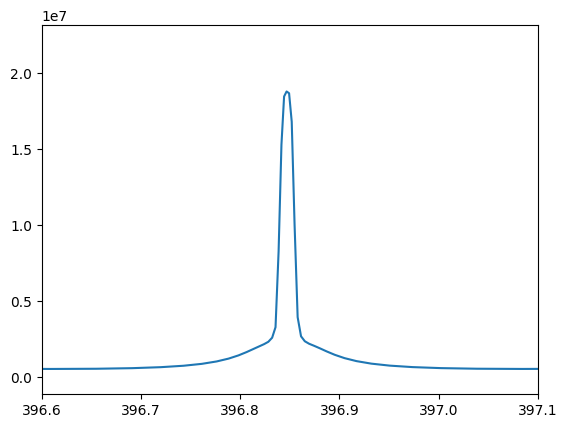

In [510]:
lamb0=396.848
plt.plot(read_rhversion_CRD['wl_rh'],read_rhversion_CRD['int_rh'])

plt.xlim([396.6,397.1])

In [512]:
import astropy.units as u
from astropy.coordinates import SpectralCoord
import astropy
def veltrans(x):
    return ((((x+lamb0)/lamb0)-1)*c)/mu

def veltrans2(x):
    return ((((x+lamb0)/lamb0)-1)*c)/mu2

def wltrans(x):
    return ((((x/c)+1)*lamb0)-lamb0)

def gaussian_psf(x, fwhm):
	#x = wavelength [nm]
	# fwhm in [nm]
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # Calculate sigma from FWHM
    tr = np.exp(-(x)**2 / (2 * (sigma**2)))
    tr /= tr.sum()
    return tr
#write adjustment for point spread function from atlas
def psf_adjust(wlsel,ilamsel,fwhm,new_dispersion_range,ntw,gaussian_psf):
    func=interp1d(wlsel,ilamsel,kind='linear',fill_value='extrapolate')
    yatlas = func(new_dispersion_range)
    dw=new_dispersion_range[1]-new_dispersion_range[0]
    dw=dw
    tw=(np.arange(ntw)-ntw//2)*dw
    
    for i in range(1):

    	psf = gaussian_psf(tw, fwhm) # guassian transmission profiles
    	yconv = convolve(yatlas, psf, mode='same', method='fft')
        
    return yconv


def doppler_shift_to_wavelength(observed_wavelength, velocity):
    """
    Converts observed wavelength to rest wavelength using the Doppler shift formula.

    Parameters:
        observed_wavelength: The observed wavelength in Angstroms (u.AA)
        velocity: The velocity of the object in km/s (u.km/s)

    Returns:
        rest_wavelength: The rest wavelength in Angstroms (u.AA)
    """

    observed_wavelength = observed_wavelength * u.nm
    velocity = velocity * u.km / u.second

    rest_wavelength = (observed_wavelength / (1 + velocity / astropy.constants.c)) - observed_wavelength

    return rest_wavelength.to(u.nm)

def doppler_shift(observed_wavelength, source_wavelength, speed_of_light=299792.458):
    """
    Calculates the Doppler shift (z) and radial velocity (v) given observed and source wavelengths.

    Args:
        observed_wavelength (float or numpy.ndarray): Observed wavelength(s).
        source_wavelength (float): Wavelength in the rest frame of the source.
        speed_of_light (float, optional): Speed of light in km/s. Defaults to 299792.458 km/s.

    Returns:
        tuple: A tuple containing:
            - doppler_shift (float or numpy.ndarray): The calculated Doppler shift (z).
            - radial_velocity (float or numpy.ndarray): The calculated radial velocity (v) in km/s.
    """
    doppler_shift = (observed_wavelength - source_wavelength) / source_wavelength
    radial_velocity = doppler_shift * speed_of_light
    return doppler_shift, radial_velocity

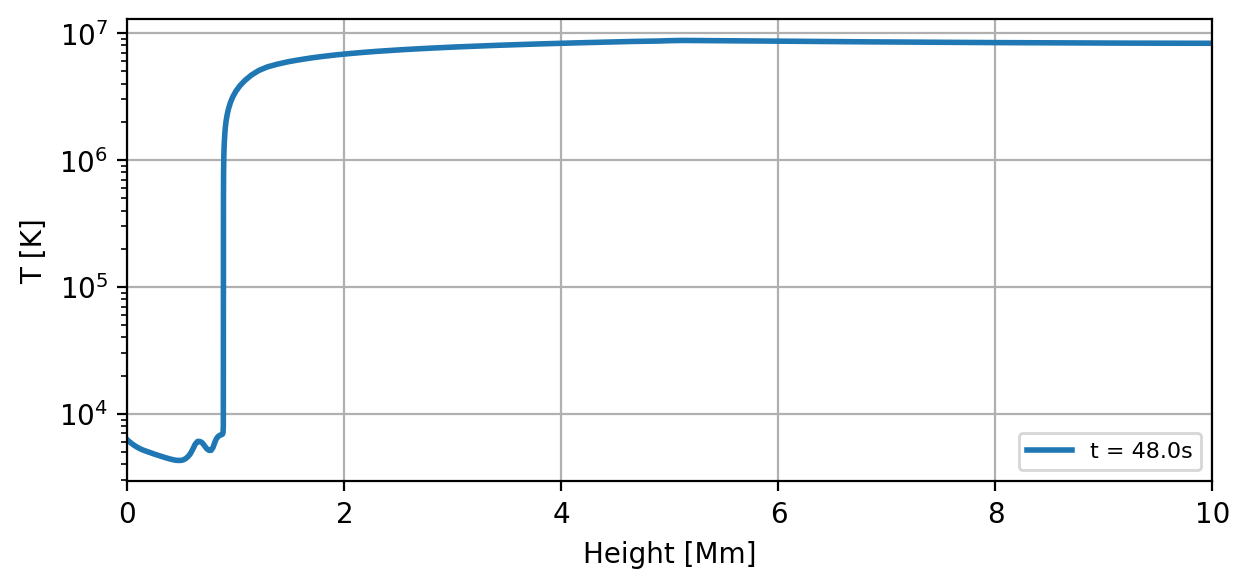

In [514]:
ncol2 = len(timesinit)#+len(times2)
map = tol_colors.tol_cmap(colormap='rainbow_discrete',lut=ncol2)
cmap_choice2 = map(np.linspace(0,1,ncol2))

#cmap_choice2 = ['#332288','#88CCEE','#44AA99','#117733','#999933','#CC6677','#AA4499','#AA4499','#AA4499','#AA4499']

fig,ax=plt.subplots(dpi=200,figsize=(7,3))
for i in range(len(timesinit)):
    ax.plot(read_oldradyn['z1t'][int(timesinit[i]),:]/1e8,(read_oldradyn['tg1t'][int(timesinit[i]),:]),label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=2)

#for i in range(len(times2)):
#    ax.plot(read['z1t'][int(times2[i]),:]/1e8,(read['tg1t'][int(times2[i]),:]),color=cmap_choice2[len(timesinit)+i],label='t = '+str(round(times2[i]/10,2))+'s',linewidth=2)

ax.grid()
ax.legend(fontsize=8)
ax.set_ylabel('T [K]')
ax.set_xlabel('Height [Mm]')
ax.set_xlim([0,10])
plt.yscale('log')

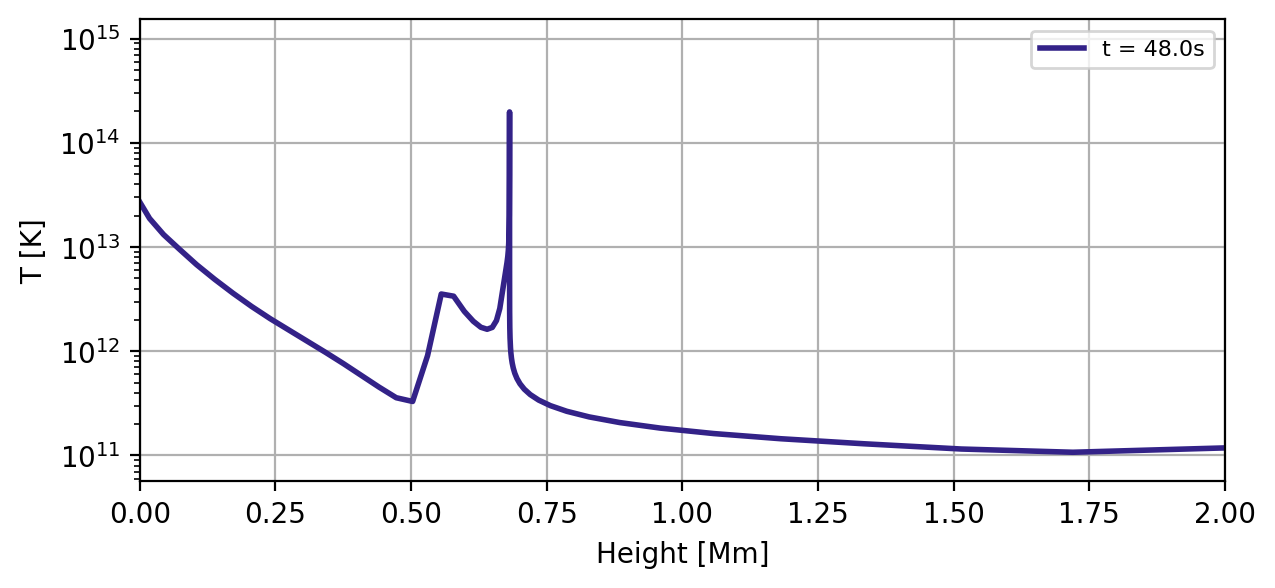

In [516]:


ncol2 = len(timesinit)#+len(times2)
map = tol_colors.tol_cmap(colormap='rainbow_discrete',lut=ncol2)
cmap_choice2 = map(np.linspace(0,1,ncol2))



cmap_choice2 = ['#332288','#88CCEE','#44AA99','#117733','#999933','#CC6677','#AA4499','#AA4499','#AA4499','#AA4499']

fig,ax=plt.subplots(dpi=200,figsize=(7,3))
for i in range(len(timesinit)):
    ax.plot(read_newradyn['z1t'][int(timesinit[i]),:]/1e8,(read_newradyn['ne1t'][int(timesinit[i]),:]),color=cmap_choice2[i],label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=2)

#for i in range(len(times2)):
#    ax.plot(read['z1t'][int(times2[i]),:]/1e8,(read['ne1t'][int(times2[i]),:]),color=cmap_choice2[len(timesinit)+i],label='t = '+str(round(times2[i]/10,2))+'s',linewidth=2)

ax.grid()
ax.legend(fontsize=8)
ax.set_ylabel('T [K]')
ax.set_xlabel('Height [Mm]')
ax.set_xlim([0,2])
plt.yscale('log')

In [519]:
q = read_oldradyn['q']
nq = read_oldradyn['nq']
qnorm = read_oldradyn['qnorm']
outintt = read_oldradyn['outintt']
nmu = read_oldradyn['nmu']

q_new = read_newradyn['q']
nq_new = read_newradyn['nq']
qnorm_new= read_newradyn['qnorm']
outintt_new = read_newradyn['outintt']
nmu_new = read_newradyn['nmu']
#q[0:nq[kr]-1,kr]*qnorm,outintt[1:nq[kr],nmu-1,kr,*]

[]

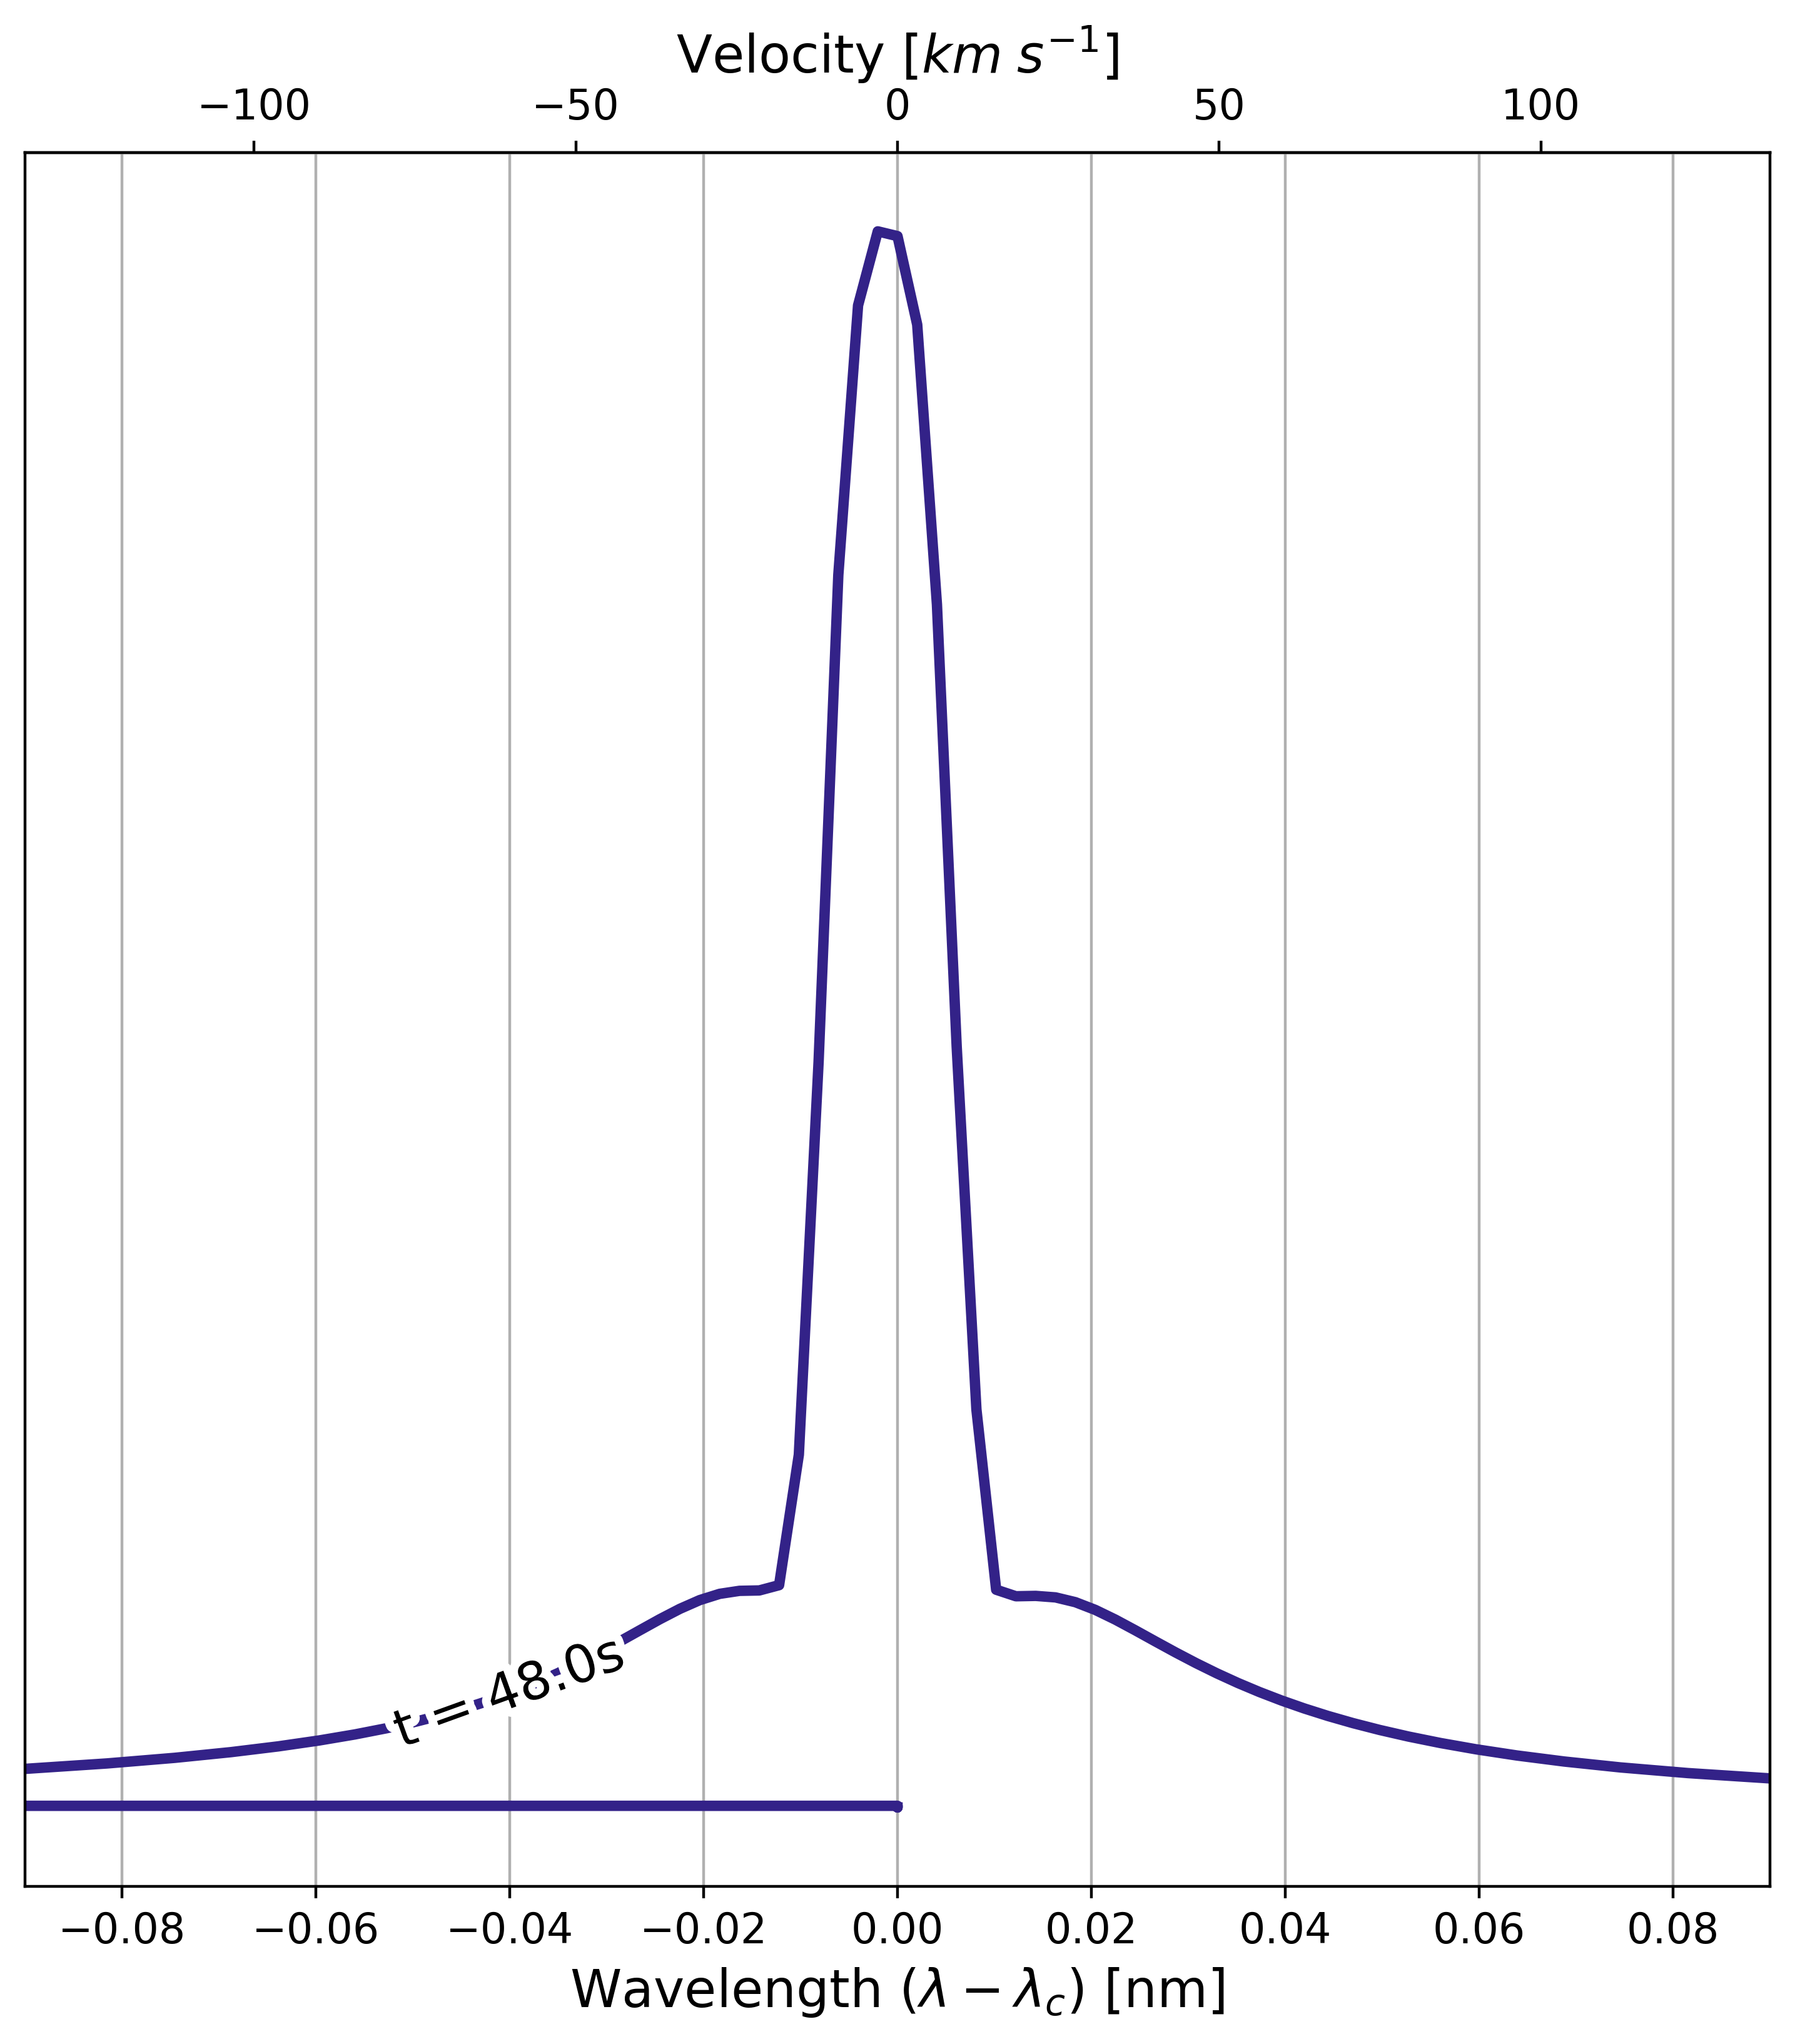

In [521]:
cmap_choice2 = ['#332288','#88CCEE','#44AA99','#117733','#999933','#CC6677','#AA4499','#AA4499','#AA4499','#AA4499']
#cmap_choice2 = plt.cm.jet(np.linspace(0,1,len(timesinit)))

wavelengths = (doppler_shift_to_wavelength(396.8,q[kr,:-1]*qnorm))

fig,ax=plt.subplots(figsize=(9,9),dpi=400)
for i in range(len(timesinit)):
    #if i==2:
    #    #ax.plot((doppler_shift_to_wavelength(396.8,q[kr,:-1]*qnorm)),(psf_adjust(wavelengths/u.nm, outintt[int(timesinit[i]),kr,muind,:-2]*1.9e11,fwhm,wavelengths/u.nm,ntw,gaussian_psf)/1e6)-(5*i),marker='o',color=cmap_choice2[i],label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=3)
    #    ax.plot((doppler_shift_to_wavelength(396.8,q[kr,:-1]*qnorm)),(psf_adjust(wavelengths/u.nm, outintt[int(timesinit[i]),kr,muind,:-2]*1.9e11-outintt[int(timesinit[0]),kr,muind,:-2]*1.9e11,fwhm,wavelengths/u.nm,ntw,gaussian_psf)/1e6)-(5*i),color=cmap_choice2[-i],label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=3)

    #else:
    ax.plot((doppler_shift_to_wavelength(396.8,q_new[kr,:-1]*qnorm_new)),(psf_adjust(wavelengths/u.nm, outintt_new[int(timesinit[i]),kr,muind,:-2]*1.9e11-outintt_new[0,kr,muind,:-2]*1.9e11,fwhm,wavelengths/u.nm,ntw,gaussian_psf)/1e6)-(5*i),color=cmap_choice2[i],label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=3)
       
    ax.set_xlim([.09,-.09])
xvals = np.zeros(30)
for i in range(len(xvals)):
    xvals[i] = -0.04
labelLines(plt.gca().get_lines(),align=True,xvals=xvals,color='k',fontsize=15)

#for i in range(len(times2)):
#    ax.plot((doppler_shift_to_wavelength(854.2,q[kr,:-110]*qnorm)),psf_adjust(wavelengths/u.nm, outintt[int(times2[i]),kr,muind,:-111]*1.9e11,fwhm,wavelengths/u.nm,ntw,gaussian_psf)/1e6,color=cmap_choice2[len(timesinit)+i],label='t = '+str(round(times2[i]/10,2))+'s',linewidth=3)
plt.gca().invert_xaxis()
#ax.legend()
#ax.axvline(0,c='black')
ax.grid()
#ax.set_ylabel(r'Intensity [$10^6\;erg\;cm^{-2}\;sr^{-1}\;\AA^{-1}$]')
secaxx = ax.secondary_xaxis('top', functions=(veltrans,wltrans))
secaxx.set_xlabel(r'Velocity $[km\; s^{-1}]$',fontsize=15)
ax.set_xlabel(r'Wavelength ($\lambda - \lambda_c$) [nm]',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)
secaxx.tick_params(axis='both', which='major', labelsize=12)
#ax.yaxis.
ax.yaxis.set_ticks([])

In [523]:
def min_max_normalize(data):
        min_val = min(data)
        max_val = max(data)
        normalized_data = [(x - min_val) / (max_val - min_val) for x in data]
        return normalized_data

In [541]:
len(read_rhversion_CRD['int_rh'])

874

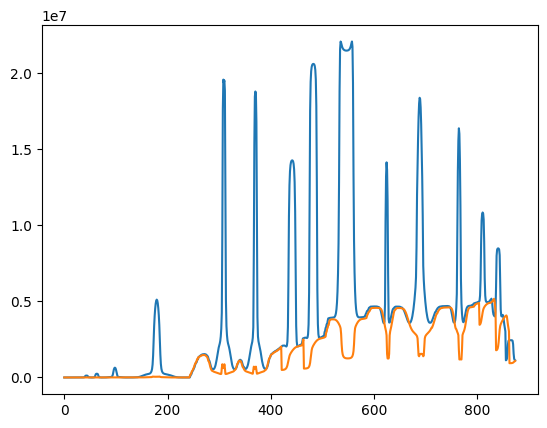

In [553]:
plt.plot(read_rhversion_CRD['int_rh'][0:874])
plt.plot(read_rhqs['int_rh'][5:879])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

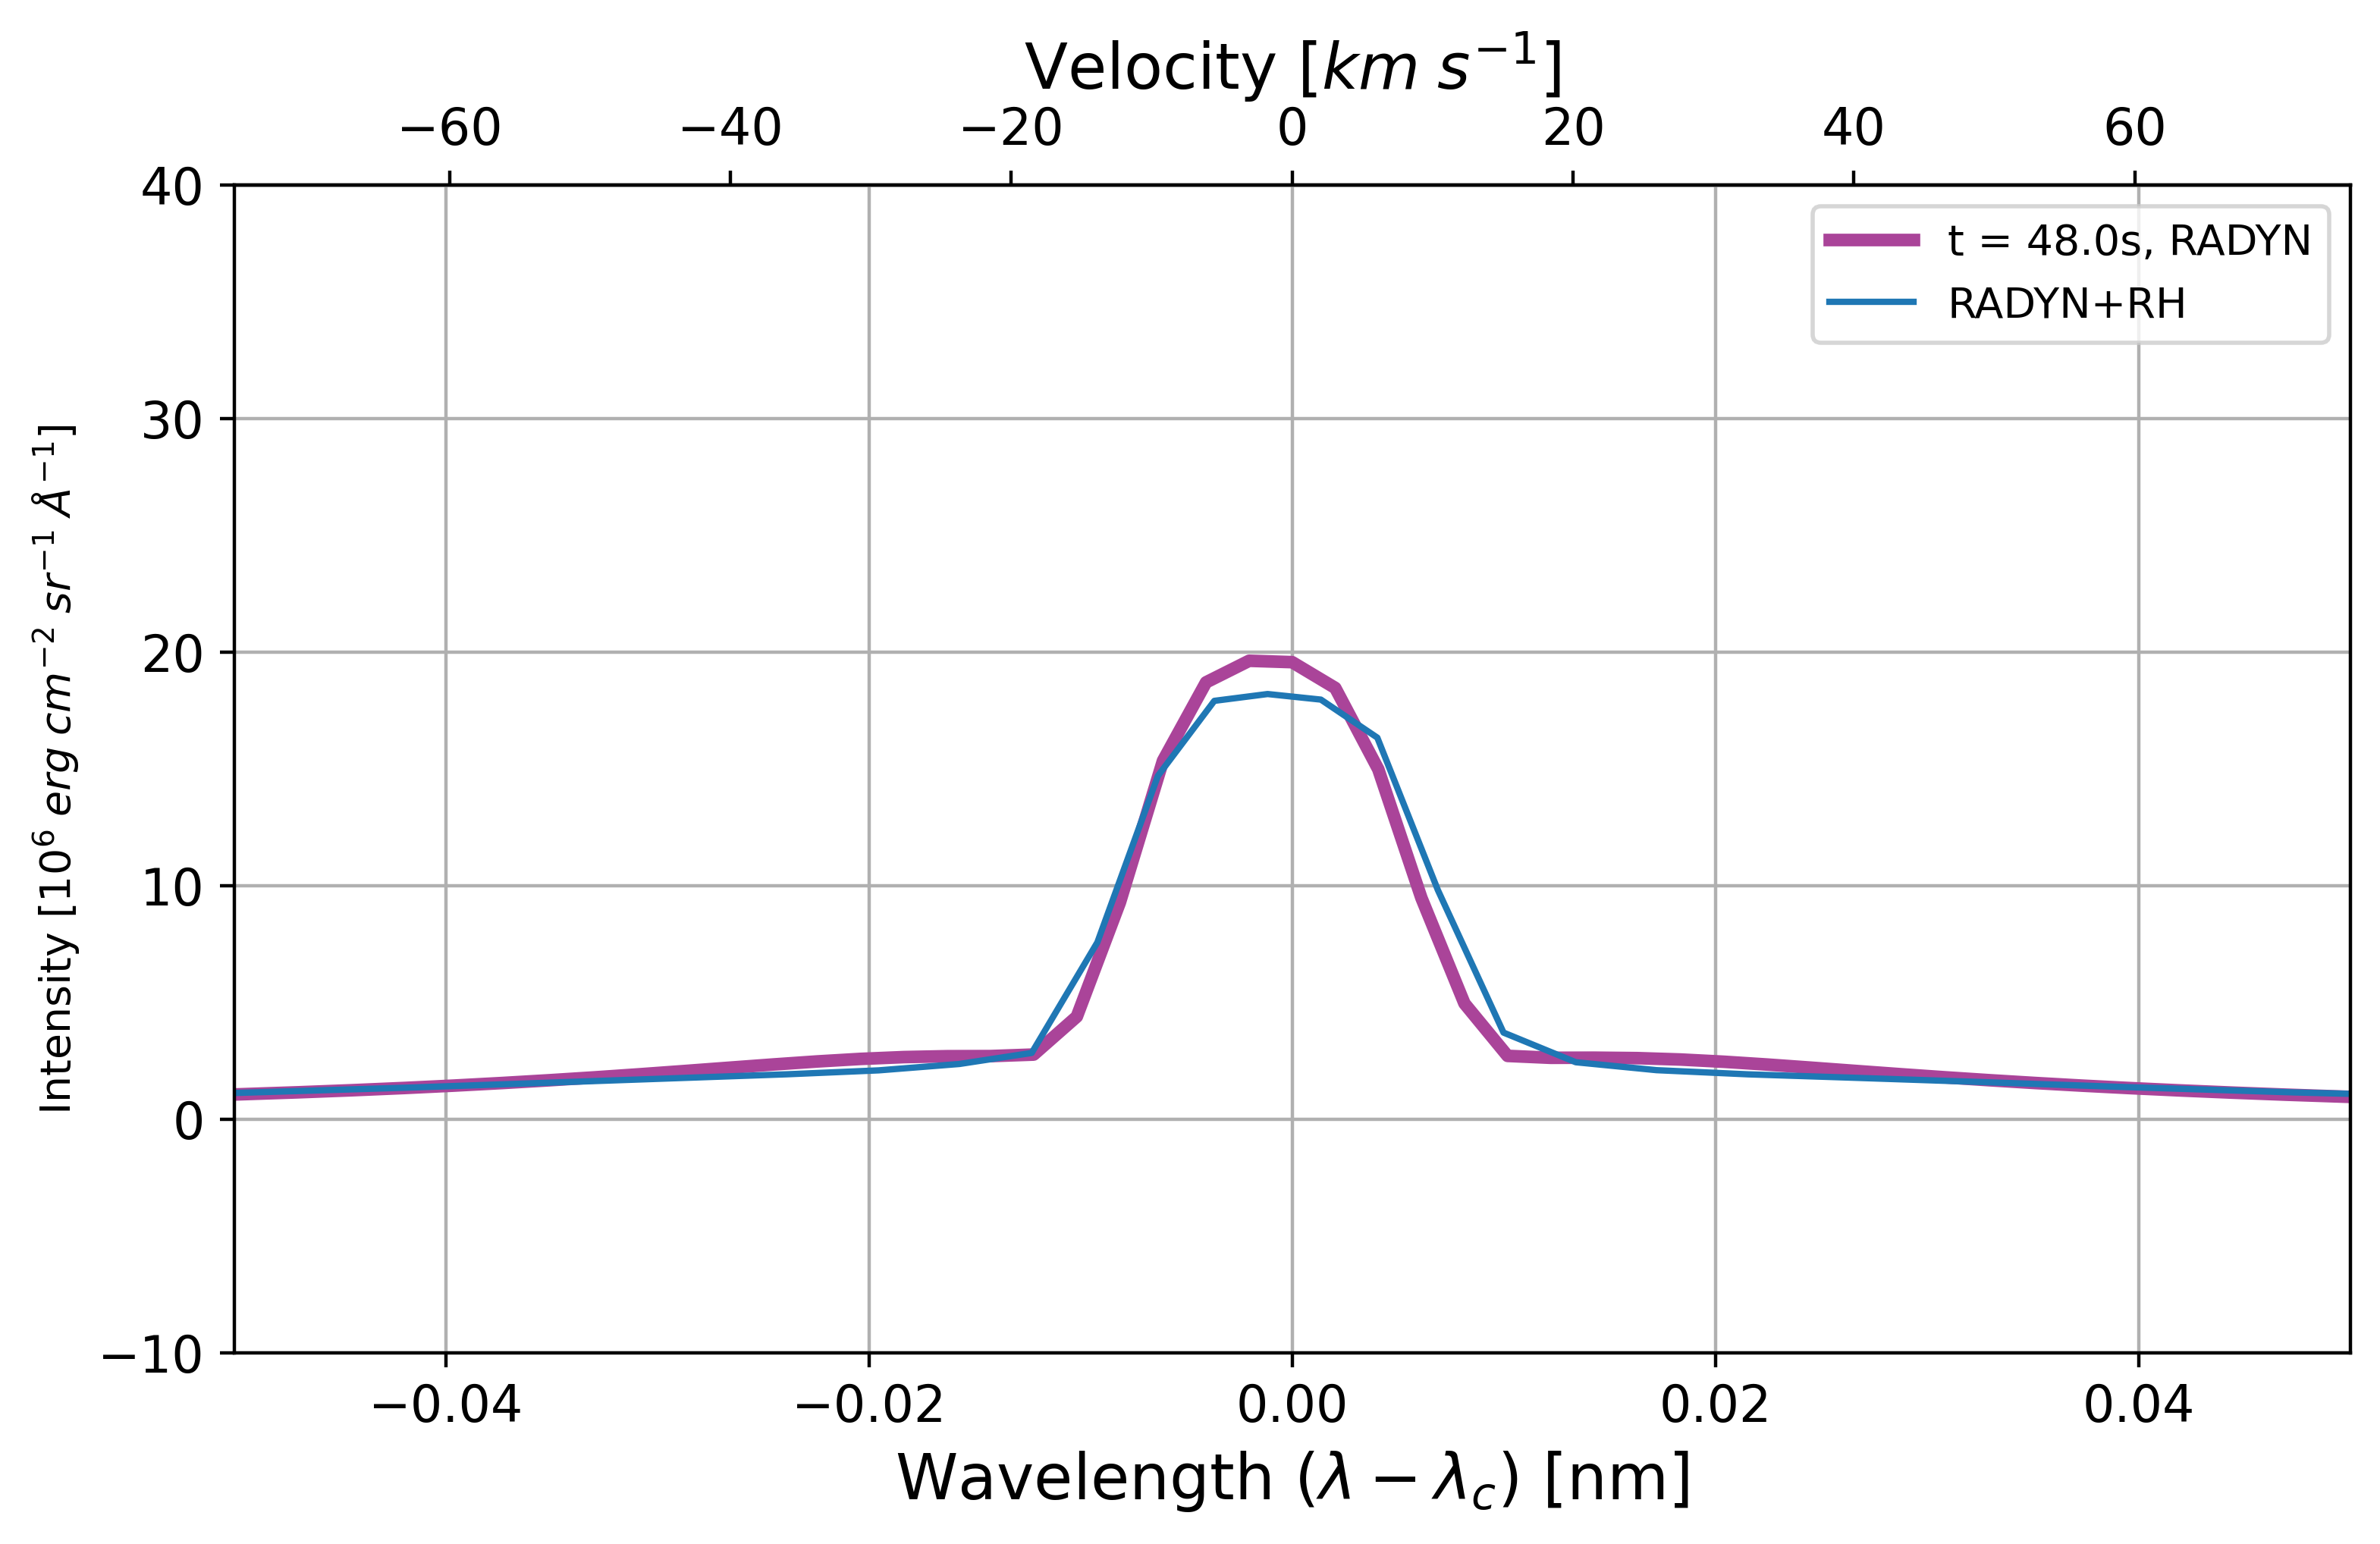

In [607]:
cmap_choice2 = ['#332288','#88CCEE','#44AA99','#117733','#999933','#CC6677','#AA4499','#AA4499','#AA4499','#AA4499']
#cmap_choice2 = plt.cm.jet(np.linspace(0,1,len(timesinit)))

line = 396.848
#line = 854.21
wavelengths = (doppler_shift_to_wavelength(line,q[kr,:-1]*qnorm))

wavelengths_rh = doppler_shift_to_wavelength(line,read_rhversion['wl_rh'])

fig,ax=plt.subplots(figsize=(9,5),dpi=400)
i=-1
#ax.plot((doppler_shift_to_wavelength(396.847,q[kr,:-1]*qnorm)),(psf_adjust(wavelengths/u.nm, (outintt[int(timesinit[i]),kr,muind,:-2]-outintt[0,kr,muind,:-2])*1.9e11,fwhm,wavelengths/u.nm,ntw,gaussian_psf)/1e6),color=cmap_choice2[i],label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=3)
#ax.plot((doppler_shift_to_wavelength(396.847,q[kr,:-1]*qnorm)),min_max_normalize(psf_adjust(wavelengths/u.nm, (outintt[int(timesinit[i]),kr,muind,:-2])*1.9e11,fwhm,wavelengths/u.nm,ntw,gaussian_psf)/1e6),color=cmap_choice2[i],label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=3)

ax.plot((doppler_shift_to_wavelength(line,q_new[kr,:-100]*qnorm_new)),((outintt_new[480,kr,muind,:-101]*1.9e11)-(outintt_new[0,kr,muind,:-101])*1.9e11)/1e6,color=cmap_choice2[i],label='t = '+str(round(timesinit[i]/10,2))+'s, RADYN',linewidth=3)
#ax.plot((doppler_shift_to_wavelength(396.847,q_new[kr,:-1]*qnorm_new)),min_max_normalize(psf_adjust(wavelengths/u.nm, (outintt_new[int(timesinit[i]),kr,muind,:-2])*1.9e11,fwhm,wavelengths/u.nm,ntw,gaussian_psf)/1e6),color=cmap_choice2[i],label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=3)
#ax.plot((doppler_shift_to_wavelength(line,q_new[kr,:-100]*qnorm_new)),((outintt_new[0,kr,muind,:-101])*1.9e11)/1e6,color=cmap_choice2[i],label='t = '+str(round(timesinit[i]/10,2))+'s, RADYN',linewidth=3)


ax.set_xlim([.09,-.09])
xvals = np.zeros(30)
for i in range(len(xvals)):
    xvals[i] = -0.04
#labelLines(plt.gca().get_lines(),align=True,xvals=xvals,color='k',fontsize=15)

#for i in range(len(times2)):
#    ax.plot((doppler_shift_to_wavelength(854.2,q[kr,:-110]*qnorm)),psf_adjust(wavelengths/u.nm, outintt[int(times2[i]),kr,muind,:-111]*1.9e11,fwhm,wavelengths/u.nm,ntw,gaussian_psf)/1e6,color=cmap_choice2[len(timesinit)+i],label='t = '+str(round(times2[i]/10,2))+'s',linewidth=3)
plt.gca().invert_xaxis()
#ax.legend()
#ax.axvline(0,c='black')
ax.grid()
ax.set_ylabel(r'Intensity [$10^6\;erg\;cm^{-2}\;sr^{-1}\;\AA^{-1}$]')
secaxx = ax.secondary_xaxis('top', functions=(veltrans,wltrans))
secaxx.set_xlabel(r'Velocity $[km\; s^{-1}]$',fontsize=15)
ax.set_xlabel(r'Wavelength ($\lambda - \lambda_c$) [nm]',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)
secaxx.tick_params(axis='both', which='major', labelsize=12)

wavelengths_rh = read_rhversion['wl_rh']-line

#ax.plot(read_rhversion['wl_rh']-line,(psf_adjust(wavelengths_rh,read_rhversion['int_rh'],fwhm,wavelengths_rh,ntw,gaussian_psf)/1e6))
ax.plot(read_rhversion_CRD['wl_rh']-line,(read_rhversion_CRD['int_rh']/1e6)-(read_rhqs['int_rh'][5:879]/1e6),label='RADYN+RH')
#ax.plot(read_rhversion_CRD['wl_rh']-line,(read_rhqs['int_rh'][5:879]/1e6),label='RADYN+RH')

#ax.plot(read_rhversion['wl_rh']-396.847,min_max_normalize(psf_adjust(wavelengths_rh,read_rhversion['int_rh'],fwhm/10,wavelengths_rh,ntw,gaussian_psf)/1e6))
#ax.set_ylim([0,0.6])
ax.set_xlim([-.05,.05])
ax.set_ylim([-10,40])
ax.legend()

In [629]:
arr = ((outintt_new[480,kr,muind,:-101]*1.9e11)-(outintt_new[0,kr,muind,:-101])*1.9e11)/1e6
x = (doppler_shift_to_wavelength(line,q_new[kr,:-100]*qnorm_new))
f = interp1d(x, arr, kind='linear')
x_new = read_rhversion_CRD['wl_rh']-line
x_new =x_new[(x_new>-5) & (x_new<5)]
resampled_arr = f(x_new)

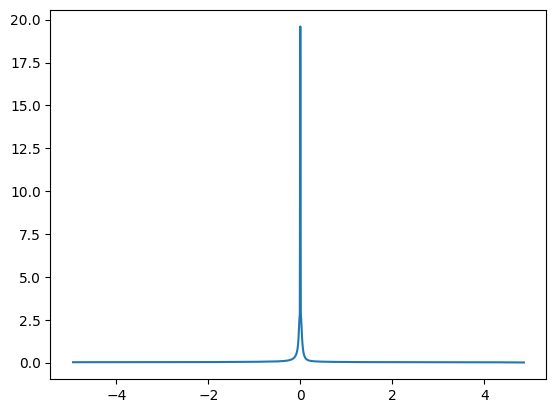

In [631]:
plt.plot(x_new,resampled_arr)

In [639]:
x = (doppler_shift_to_wavelength(line,q_new[kr,:-100]*qnorm_new))
f = interp1d(x, arr, kind='linear')
x_new = read_rhversion_CRD['wl_rh']-line
x_new2 = x_new[(x_new>-5) & (x_new<5)]

In [641]:
x_new2

array([-4.93896255e+00, -4.85935975e+00, -4.63290841e+00, -4.39260614e+00,
       -4.20383890e+00, -4.05546384e+00, -3.93874739e+00, -3.84684435e+00,
       -3.82017735e+00, -3.77438959e+00, -3.71717800e+00, -3.67191374e+00,
       -3.63601354e+00, -3.60745273e+00, -3.58464438e+00, -3.56634471e+00,
       -3.55157885e+00, -3.53958272e+00, -3.52975746e+00, -3.52163367e+00,
       -3.51484348e+00, -3.50909852e+00, -3.50417281e+00, -3.49988920e+00,
       -3.49610886e+00, -3.49272297e+00, -3.48964625e+00, -3.48681184e+00,
       -3.48416736e+00, -3.48167173e+00, -3.47917610e+00, -3.47653162e+00,
       -3.47369721e+00, -3.47062049e+00, -3.46723460e+00, -3.46345426e+00,
       -3.45917065e+00, -3.45424494e+00, -3.44849998e+00, -3.44170979e+00,
       -3.43358600e+00, -3.42376074e+00, -3.41176461e+00, -3.39699875e+00,
       -3.37869908e+00, -3.35589073e+00, -3.32732992e+00, -3.29142973e+00,
       -3.24616546e+00, -3.18895388e+00, -3.11649912e+00, -3.02459608e+00,
       -3.00525953e+00, -

In [675]:
percdiff

array([ 3.82196680e+00,  2.93436615e+00,  2.53668738e-02, -3.24750668e+00,
       -6.26182654e+00, -8.02727616e+00, -8.07626485e+00, -5.50975028e+00,
       -2.43295242e-01,  7.34684388e+00,  1.62963142e+01,  2.39440432e+01,
        2.49760900e+01,  1.41075906e+01, -2.55540933e+00, -1.12035235e+01,
       -4.95897432e-01,  5.41199278e+00,  7.68067525e+00,  4.82897331e+00,
       -7.82714938e+00, -2.10384889e+01, -2.11944278e+01,  7.89745550e+00,
        2.32759018e+01,  2.45488495e+01,  1.67711708e+01,  6.76457934e+00,
       -2.21059125e+00, -9.49596510e+00, -1.54145910e+01, -2.04359528e+01,
       -2.38354386e+01, -2.57817718e+01, -2.48440160e+01, -2.08504487e+01,
       -8.05912343e+00])

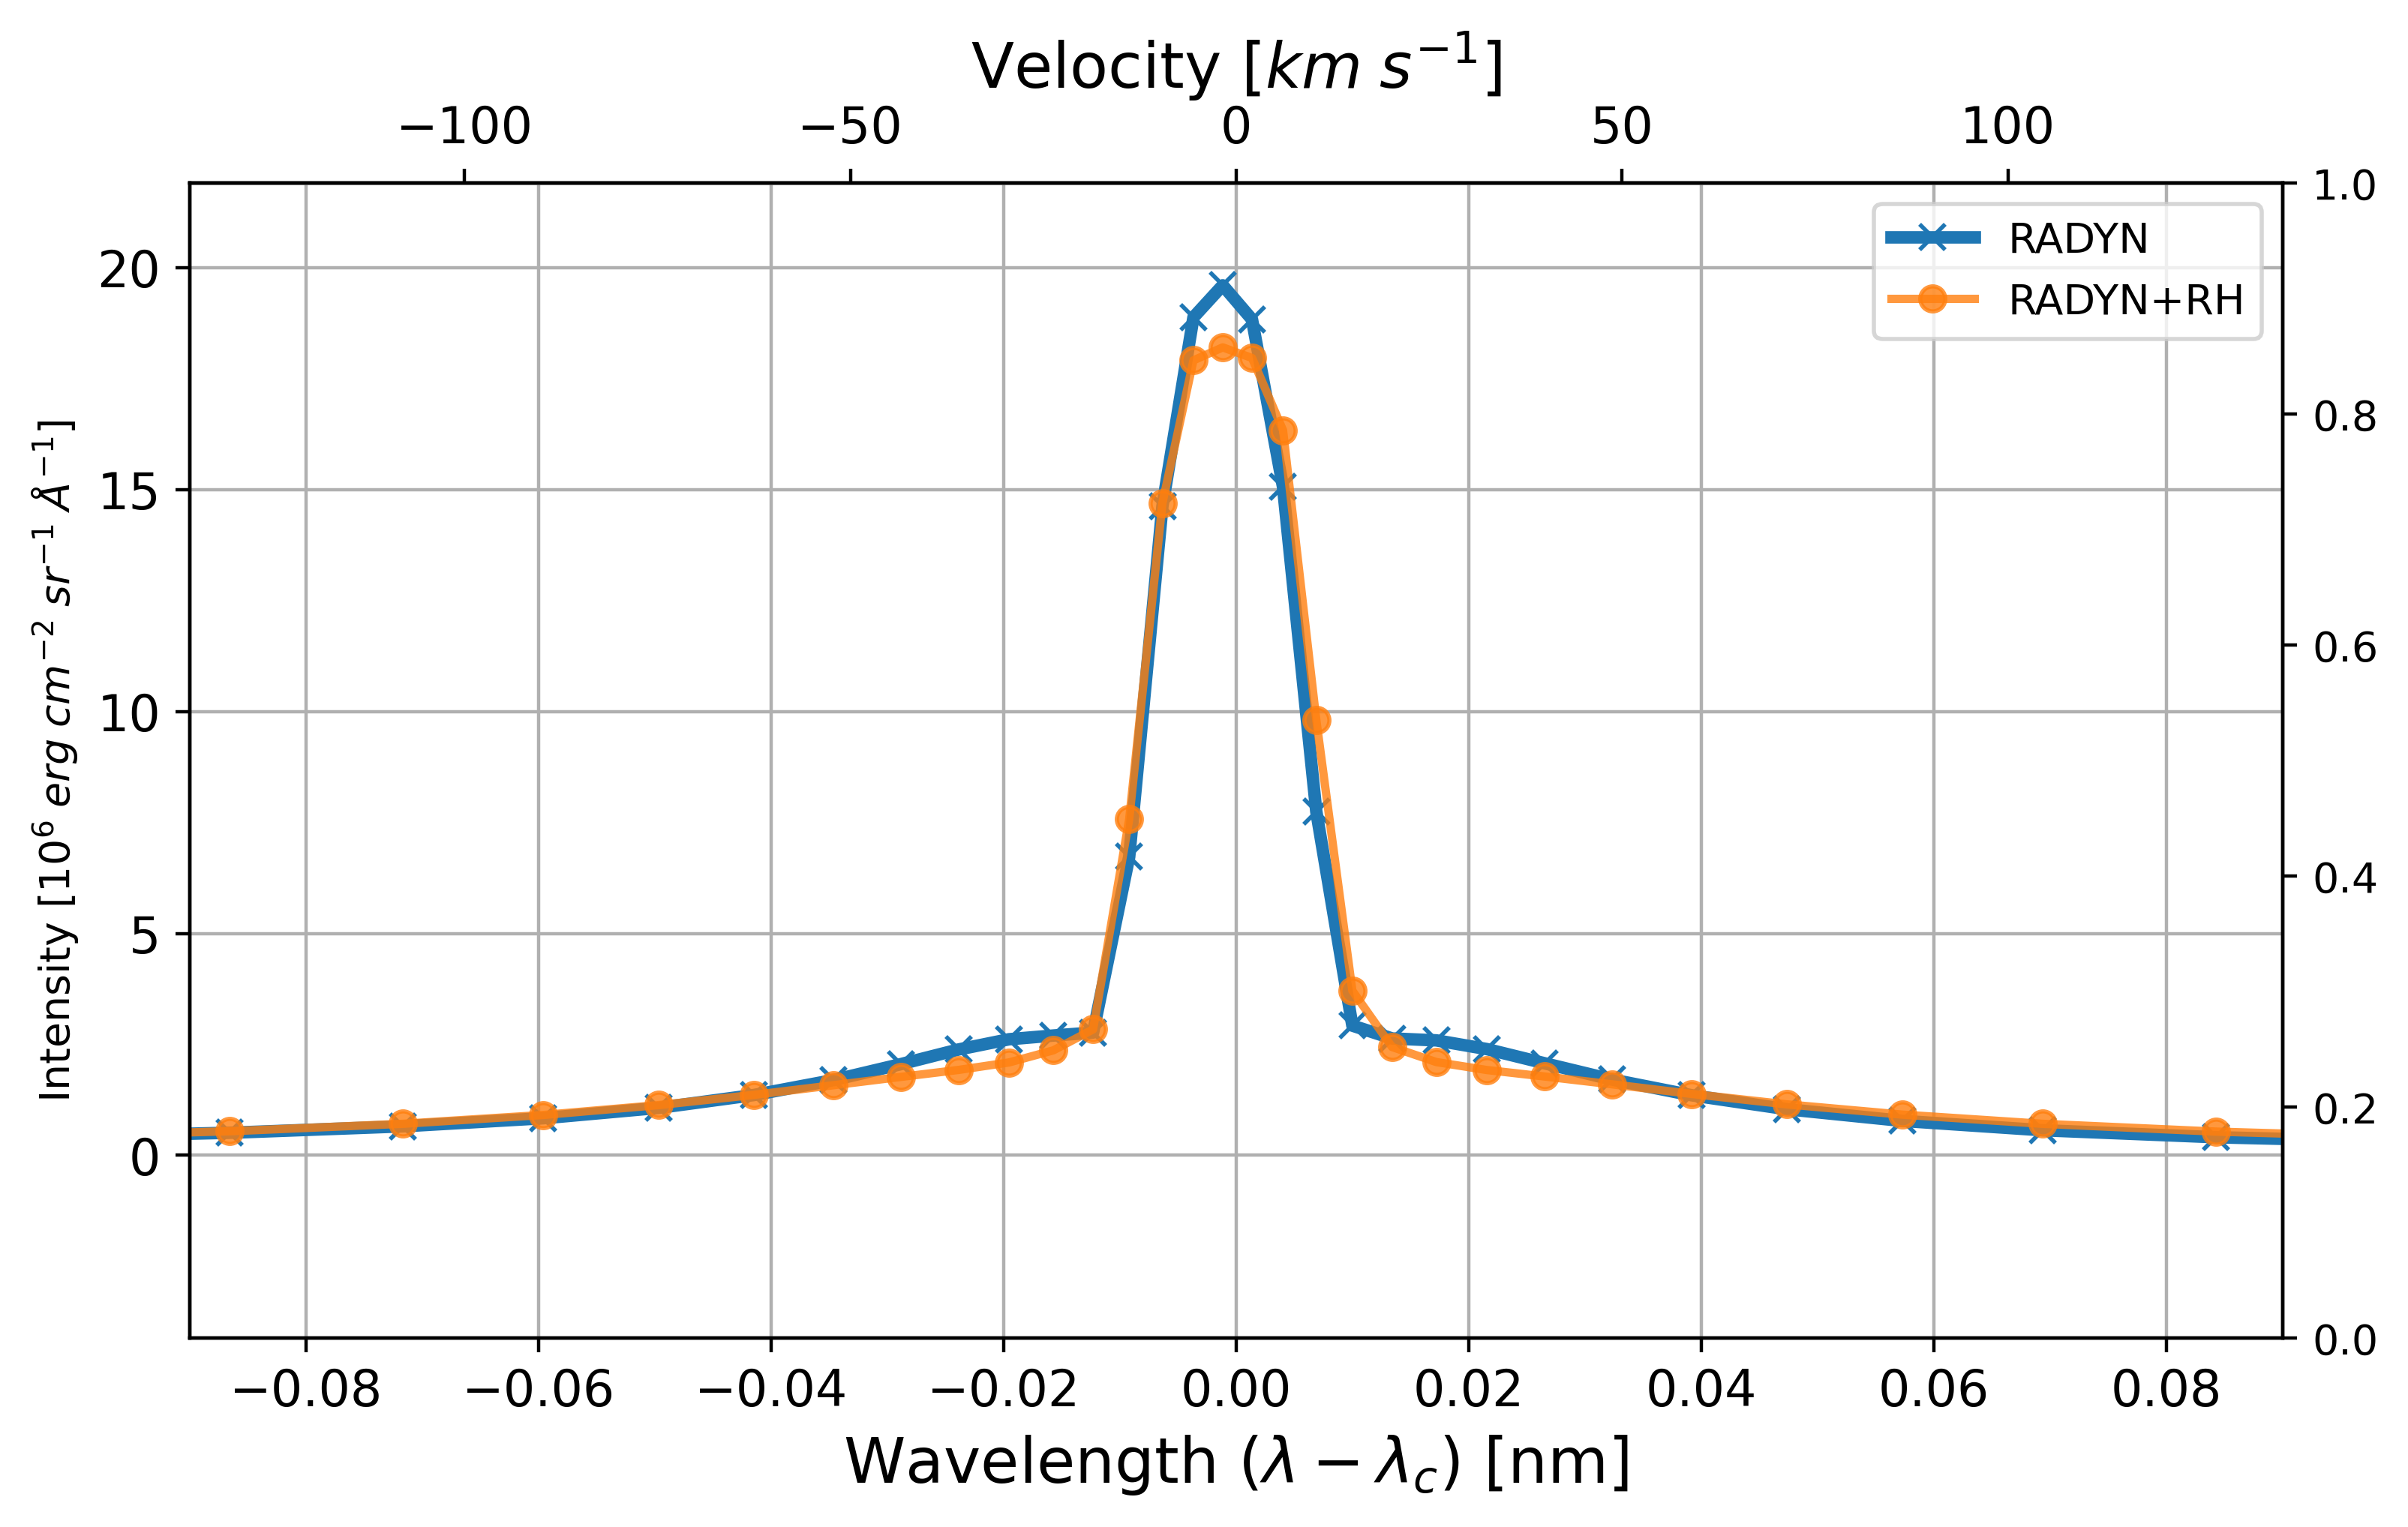

In [720]:
cmap_choice2 = ['#332288','#88CCEE','#44AA99','#117733','#999933','#CC6677','#AA4499','#AA4499','#AA4499','#AA4499']
#cmap_choice2 = plt.cm.jet(np.linspace(0,1,len(timesinit)))

line = 396.848
#line = 854.21


fig,ax=plt.subplots(figsize=(9,5),dpi=400)
i=-1




#ax.plot((doppler_shift_to_wavelength(396.847,q[kr,:-1]*qnorm)),(psf_adjust(wavelengths/u.nm, (outintt[int(timesinit[i]),kr,muind,:-2]-outintt[0,kr,muind,:-2])*1.9e11,fwhm,wavelengths/u.nm,ntw,gaussian_psf)/1e6),color=cmap_choice2[i],label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=3)
#ax.plot((doppler_shift_to_wavelength(396.847,q[kr,:-1]*qnorm)),min_max_normalize(psf_adjust(wavelengths/u.nm, (outintt[int(timesinit[i]),kr,muind,:-2])*1.9e11,fwhm,wavelengths/u.nm,ntw,gaussian_psf)/1e6),color=cmap_choice2[i],label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=3)

arr = ((outintt_new[480,kr,muind,:-101]*1.9e11)-(outintt_new[0,kr,muind,:-101])*1.9e11)/1e6
x = (doppler_shift_to_wavelength(line,q_new[kr,:-100]*qnorm_new))
f = interp1d(x, arr, kind='linear')
x_new = read_rhversion_CRD['wl_rh']-line
x_new2 = x_new[(x_new>-5) & (x_new<5)]
resampled_arr = f(x_new2)
ax.plot(x_new2,resampled_arr,label='RADYN',marker='x',linewidth=3)
#ax.plot((doppler_shift_to_wavelength(line,q_new[kr,:-100]*qnorm_new)),((outintt_new[480,kr,muind,:-101]*1.9e11)-(outintt_new[0,kr,muind,:-101])*1.9e11)/1e6,color=cmap_choice2[i],label='t = '+str(round(timesinit[i]/10,2))+'s, RADYN',linewidth=3)
#ax.plot((doppler_shift_to_wavelength(396.847,q_new[kr,:-1]*qnorm_new)),min_max_normalize(psf_adjust(wavelengths/u.nm, (outintt_new[int(timesinit[i]),kr,muind,:-2])*1.9e11,fwhm,wavelengths/u.nm,ntw,gaussian_psf)/1e6),color=cmap_choice2[i],label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=3)
#ax.plot((doppler_shift_to_wavelength(line,q_new[kr,:-100]*qnorm_new)),((outintt_new[0,kr,muind,:-101])*1.9e11)/1e6,color=cmap_choice2[i],label='t = '+str(round(timesinit[i]/10,2))+'s, RADYN',linewidth=3)


ax.set_xlim([.09,-.09])
xvals = np.zeros(30)
for i in range(len(xvals)):
    xvals[i] = -0.04
#labelLines(plt.gca().get_lines(),align=True,xvals=xvals,color='k',fontsize=15)

#for i in range(len(times2)):
#    ax.plot((doppler_shift_to_wavelength(854.2,q[kr,:-110]*qnorm)),psf_adjust(wavelengths/u.nm, outintt[int(times2[i]),kr,muind,:-111]*1.9e11,fwhm,wavelengths/u.nm,ntw,gaussian_psf)/1e6,color=cmap_choice2[len(timesinit)+i],label='t = '+str(round(times2[i]/10,2))+'s',linewidth=3)
plt.gca().invert_xaxis()
#ax.legend()
#ax.axvline(0,c='black')
ax.grid()
ax.set_ylabel(r'Intensity [$10^6\;erg\;cm^{-2}\;sr^{-1}\;\AA^{-1}$]')
secaxx = ax.secondary_xaxis('top', functions=(veltrans,wltrans))
secaxx.set_xlabel(r'Velocity $[km\; s^{-1}]$',fontsize=15)
ax.set_xlabel(r'Wavelength ($\lambda - \lambda_c$) [nm]',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)
secaxx.tick_params(axis='both', which='major', labelsize=12)


#ax.plot(read_rhversion['wl_rh']-line,(psf_adjust(wavelengths_rh,read_rhversion['int_rh'],fwhm,wavelengths_rh,ntw,gaussian_psf)/1e6))
ax.plot(read_rhversion_CRD['wl_rh']-line,(read_rhversion_CRD['int_rh']/1e6)-(read_rhqs['int_rh'][5:879]/1e6),label='RADYN+RH',marker='o',linewidth=2,alpha=0.8)
#ax.plot(read_rhversion_CRD['wl_rh']-line,(read_rhqs['int_rh'][5:879]/1e6),label='RADYN+RH')

shift = read_rhversion_CRD['wl_rh']-line
inds1 = np.where((shift>-0.2) & (shift<0.2))
inds2 = np.where((x_new2>-0.2) & (x_new2<0.2))

percdiff = 100*((resampled_arr[inds2]-rhv[inds1])/rhv[inds1])
ax2 = ax.twinx()
#ax2.plot(x_new2[inds2],percdiff,c='#CC6677',marker='s')
#ax2.set_ylim([-50,50])
#ax2.set_ylabel('% Difference')
#ax.plot(read_rhversion['wl_rh']-396.847,min_max_normalize(psf_adjust(wavelengths_rh,read_rhversion['int_rh'],fwhm/10,wavelengths_rh,ntw,gaussian_psf)/1e6))
#ax.set_ylim([0,0.6])
#ax.set_xlim([-.05,.05])
#ax.set_ylim([-10,28])
ax.legend()


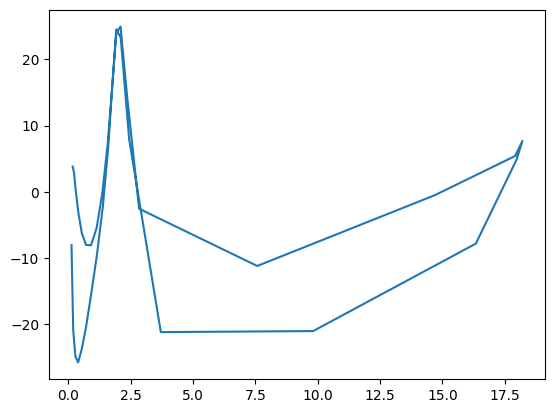

In [697]:
plt.plot(rhv[inds1],percdiff)


In [256]:
def tosi(self, wav, s):
    clight=2.99792458e8      #speed of light [m/s]                                  
    aa_to_m=1e-10                                                                        
    cm_to_m=1e-2                       
    s /= cm_to_m**2 * aa_to_m # from from Watt /(s cm2 ster AA) to Watt/(s m2 ster m) 
    s *= (wav*aa_to_m)**2 / clight # to Watt/(s m2 Hz ster)
    return s

In [258]:
# I think 1.9e11 is the conversion...

In [260]:
q = read['q']
nq = read['nq']
qnorm = read['qnorm']
outintt = read['outintt']
nmu = read['nmu']
#q[0:nq[kr]-1,kr]*qnorm,outintt[1:nq[kr],nmu-1,kr,*]

In [262]:
timesinit

[0, 66.7, 133.3, 200, 250, 430, 500]

In [264]:
import label

ModuleNotFoundError: No module named 'label'

In [266]:
len(outintt[int(timesinit[i]),kr,muind,:-101])

101

[]

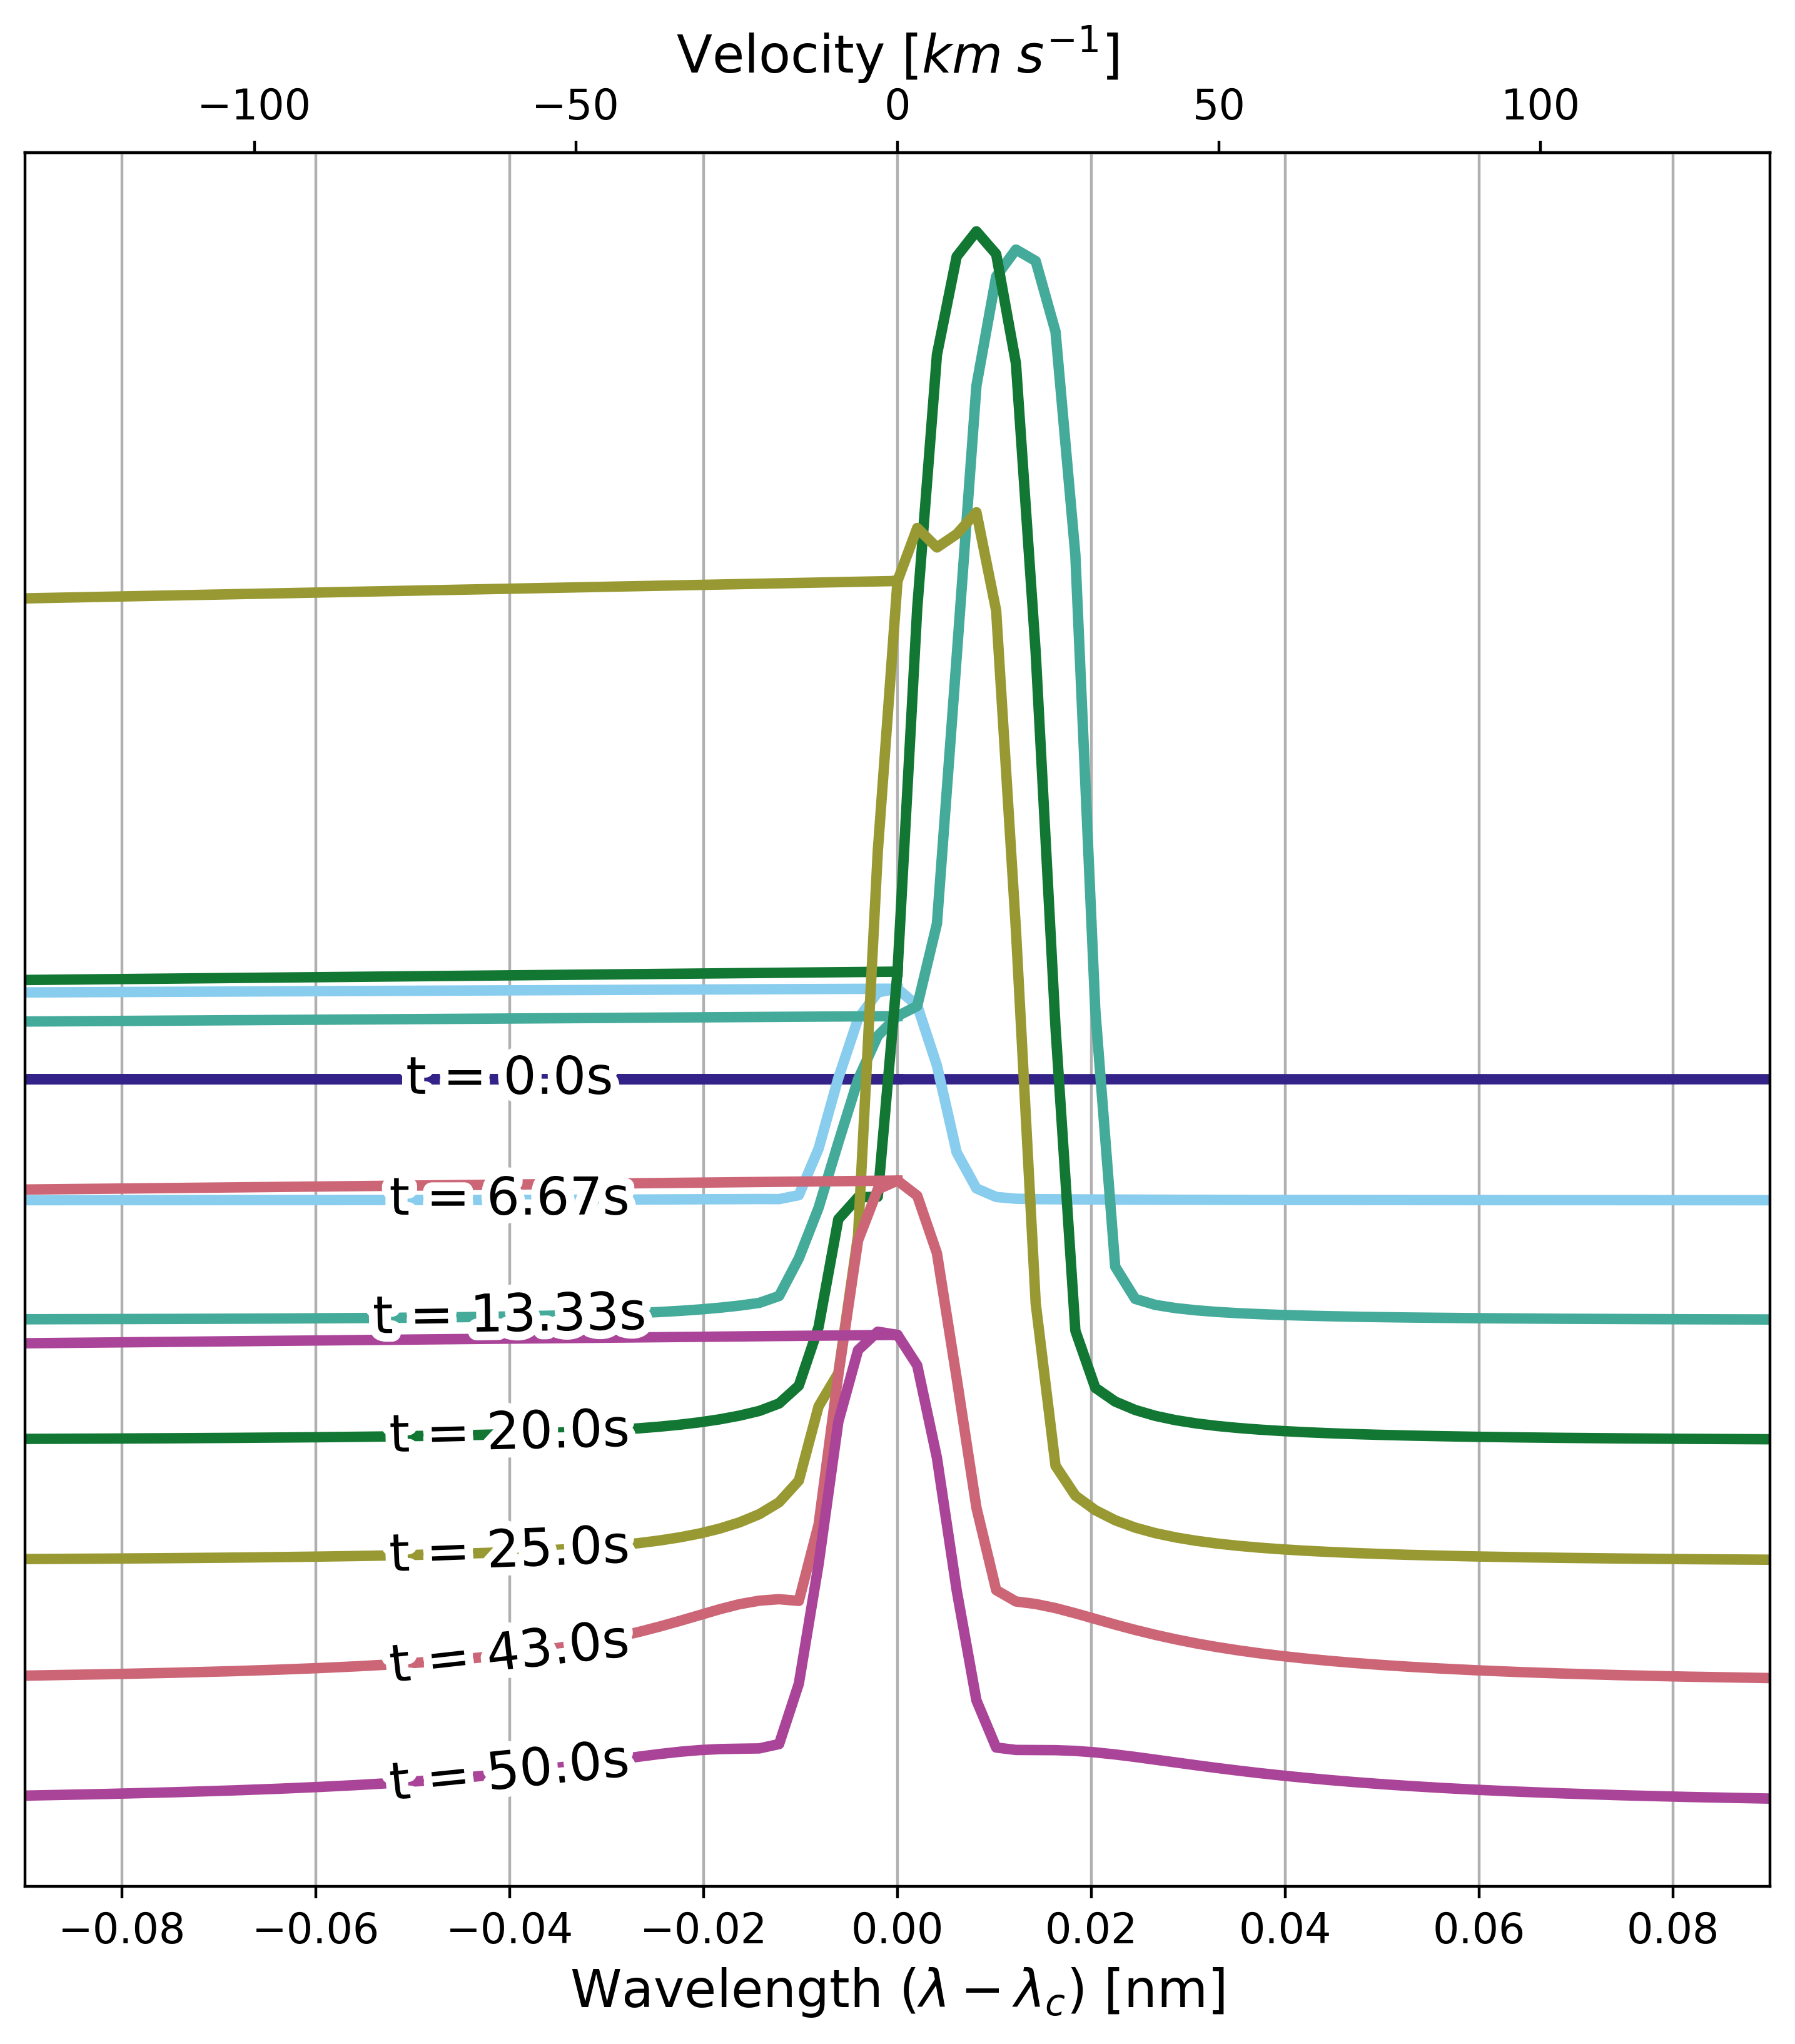

In [268]:


cmap_choice2 = ['#332288','#88CCEE','#44AA99','#117733','#999933','#CC6677','#AA4499','#AA4499','#AA4499','#AA4499']
#cmap_choice2 = plt.cm.jet(np.linspace(0,1,len(timesinit)))

wavelengths = (doppler_shift_to_wavelength(396.8,q[kr,:-1]*qnorm))

fig,ax=plt.subplots(figsize=(9,9),dpi=400)
for i in range(len(timesinit)):
    #if i==2:
    #    #ax.plot((doppler_shift_to_wavelength(396.8,q[kr,:-1]*qnorm)),(psf_adjust(wavelengths/u.nm, outintt[int(timesinit[i]),kr,muind,:-2]*1.9e11,fwhm,wavelengths/u.nm,ntw,gaussian_psf)/1e6)-(5*i),marker='o',color=cmap_choice2[i],label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=3)
    #    ax.plot((doppler_shift_to_wavelength(396.8,q[kr,:-1]*qnorm)),(psf_adjust(wavelengths/u.nm, outintt[int(timesinit[i]),kr,muind,:-2]*1.9e11-outintt[int(timesinit[0]),kr,muind,:-2]*1.9e11,fwhm,wavelengths/u.nm,ntw,gaussian_psf)/1e6)-(5*i),color=cmap_choice2[-i],label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=3)

    #else:
    ax.plot(((,q[kr,:-1]*qnorm),(psf_adjust(wavelengths/u.nm, outintt[int(timesinit[i]),kr,muind,:-2]*1.9e11-outintt[int(timesinit[0]),kr,muind,:-2]*1.9e11,fwhm,wavelengths/u.nm,ntw,gaussian_psf)/1e6)-(5*i),color=cmap_choice2[i],label='t = '+str(round(timesinit[i]/10,2))+'s',linewidth=3)
       
    ax.set_xlim([.09,-.09])
xvals = np.zeros(30)
for i in range(len(xvals)):
    xvals[i] = -0.04
labelLines(plt.gca().get_lines(),align=True,xvals=xvals,color='k',fontsize=15)

#for i in range(len(times2)):
#    ax.plot((doppler_shift_to_wavelength(854.2,q[kr,:-110]*qnorm)),psf_adjust(wavelengths/u.nm, outintt[int(times2[i]),kr,muind,:-111]*1.9e11,fwhm,wavelengths/u.nm,ntw,gaussian_psf)/1e6,color=cmap_choice2[len(timesinit)+i],label='t = '+str(round(times2[i]/10,2))+'s',linewidth=3)
plt.gca().invert_xaxis()
#ax.legend()
#ax.axvline(0,c='black')
ax.grid()
#ax.set_ylabel(r'Intensity [$10^6\;erg\;cm^{-2}\;sr^{-1}\;\AA^{-1}$]')
secaxx = ax.secondary_xaxis('top', functions=(veltrans,wltrans))
secaxx.set_xlabel(r'Velocity $[km\; s^{-1}]$',fontsize=15)
ax.set_xlabel(r'Wavelength ($\lambda - \lambda_c$) [nm]',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)
secaxx.tick_params(axis='both', which='major', labelsize=12)
#ax.yaxis.
ax.yaxis.set_ticks([])

In [83]:
!pip install matplotlib-label-lines

In [248]:
lines = plt.gca().get_lines()
l1=lines[-1]
labelLine(l1,0.6,label=r'$Re=${}'.format(l1.get_label()),ha='left',va='bottom',align = False)
labelLines(lines[:-1],align=False)

SyntaxError: invalid syntax (1943292161.py, line 1)

In [85]:
from labellines import *